In [2]:
import numpy as np
import sklearn
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import zipfile

In [3]:
class PUFSimulator:
    def __init__(self, stages_num):
        self.stages_num=stages_num
        self.crossed_path_delays=np.random.uniform(size=stages_num)
        self.uncrossed_path_delays=np.random.uniform(size=stages_num)
        self.w=np.zeros(stages_num+1)
        self.w[1:]=(self.crossed_path_delays+self.uncrossed_path_delays)/2
        self.w[:stages_num]+=(self.uncrossed_path_delays-self.crossed_path_delays)/2
        
    def get_responses(self, challenges):
        def calculate_response(challenge):
            return np.heaviside(np.dot(self.w, self.get_feature_vector(challenge).T), 1)
        return np.apply_along_axis(calculate_response,axis=1,arr=challenges)
    
    def get_feature_vector(self, challenge):
        feature_vector=np.ones(challenge.shape[0]+1)
        for i in reversed(range(challenge.shape[0])):
            feature_vector[i]=feature_vector[i+1]*(1-2*challenge[i])
        return feature_vector
    
    def generate_challenges(self, challenges_num):
        return np.random.randint(0, 2, [challenges_num, self.stages_num])
    

In [31]:
puf_simulator=PUFSimulator(16)
challenges=puf_simulator.generate_challenges(10000)
X=np.apply_along_axis(puf_simulator.get_feature_vector,axis=1,arr=challenges)
y=puf_simulator.get_responses(challenges)

In [33]:
print(f"0 quantity: {(y==0).sum()}")
print(f"1 quantity: {(y==1).sum()}")

0 quantity: 3651
1 quantity: 6349


In [10]:
def plot_learning_curves(estimator, X_train, y_train, scorers, dataset_name):
    fig, axes = plt.subplots(1, len(scorers), figsize=(12, 6))
    if len(scorers)==1:
        axes=[axes]
    errors={}
    for scorer,ax in zip(scorers, axes):
        train_sz, train_errs, cv_errs = learning_curve(estimator=estimator, X=X_train, y=y_train, cv=5,
                                                      train_sizes=np.linspace(0.1, 1, 20),
                                                      scoring=scorer)  
        tr_err = np.mean(train_errs, axis=1)
        cv_err = np.mean(cv_errs, axis=1)
        errors[scorer._score_func.__name__]=(train_sz, tr_err, cv_err)
        ax.plot(train_sz, tr_err, linestyle="--", color="r", label="training error")
        ax.plot(train_sz, cv_err, linestyle="-", color="b", label="cv error")
        ax.set_xlabel("Dataset size")
        ax.set_ylabel("Score")
        ax.set_title(f"{estimator.__class__ .__name__} evaluation using\n {scorer._score_func.__name__} on {dataset_name} dataset")
        ax.legend(loc="lower right")
    return errors

In [154]:
def evaluate_models(X, y, dataset_name, scorers):
    print(f"Evaluating logistic regression on {dataset_name} dataset")
    lr=LogisticRegression(solver='liblinear')
    lr_errs=plot_learning_curves(lr, X, y, scorers, dataset_name=dataset_name)
    print(f"Evaluating SVM on {dataset_name} dataset")
    svm=SVC(C=1, gamma='scale')
    svm_errs=plot_learning_curves(svm, X, y, scorers, dataset_name=dataset_name)
    print(f"Evaluating MLP on {dataset_name} dataset")
    mlp=MLPClassifier(
        hidden_layer_sizes=(puf_simulator.stages_num),
        alpha=1e-3,
        max_iter=1000
    )
    mlp_errs=plot_learning_curves(mlp, X, y, scorers, dataset_name=dataset_name)
    print(f"Evaluating gradient boosting on {dataset_name} dataset")
    gb=GradientBoostingClassifier(n_estimators=400, max_depth=3)
    gb_errs=plot_learning_curves(gb, X, y, scorers, dataset_name=dataset_name)
    return {
        "LogisticRegression":lr_errs,
        "SVM":svm_errs,
        "MLP":mlp_errs,
        "GradientBoosting":gb_errs
    }

Evaluating logistic regression on generated dataset
Evaluating SVM on generated dataset
Evaluating MLP on generated dataset
Evaluating gradient boosting on generated dataset


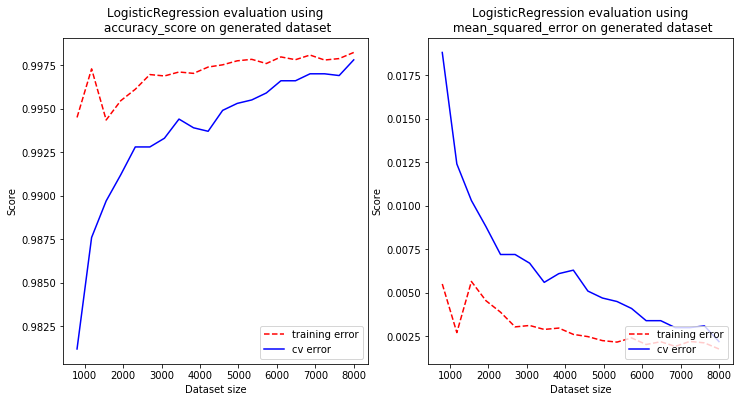

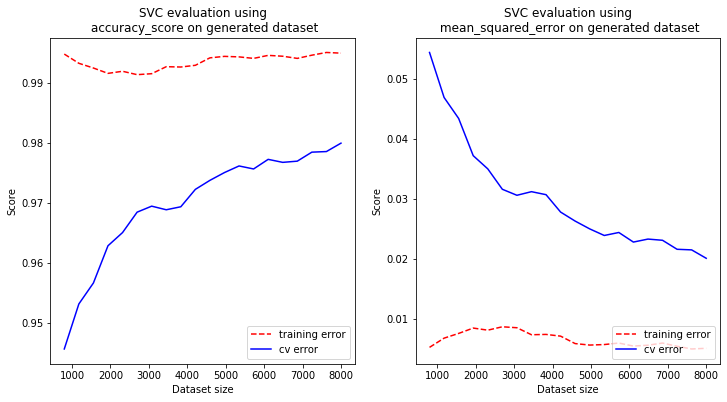

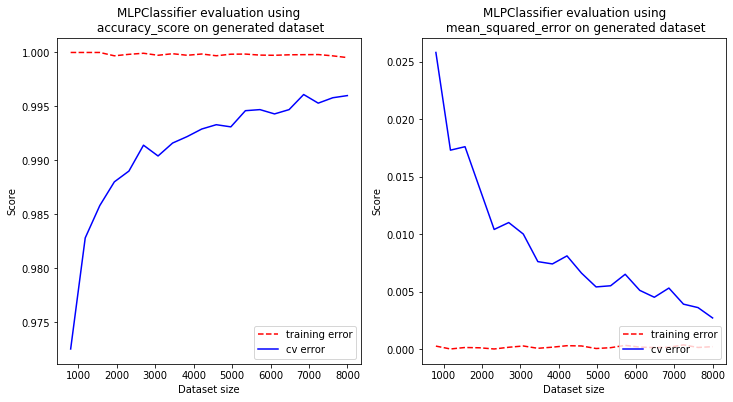

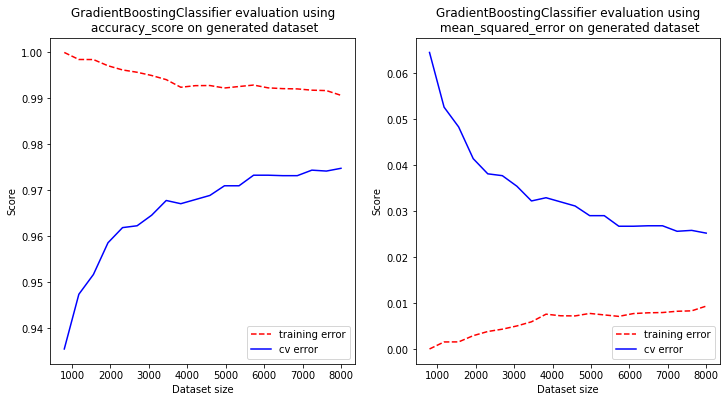

In [155]:
accuracy_scorer=make_scorer(accuracy_score)
mse_scorer=make_scorer(mean_squared_error)
scorers=[accuracy_scorer, mse_scorer]
models_errs=evaluate_models(X, y, "generated", scorers)

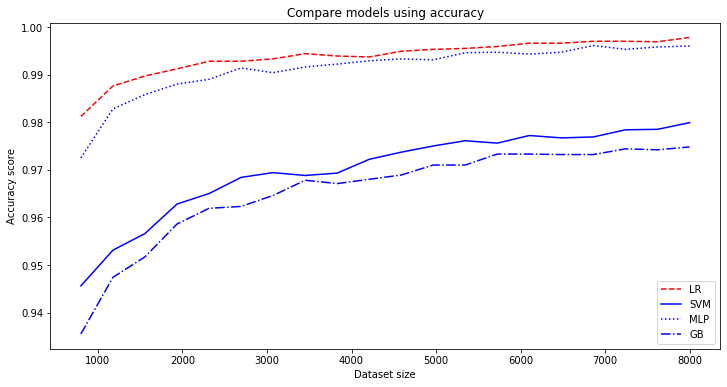

In [156]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(models_errs["LogisticRegression"]["accuracy_score"][0], models_errs["LogisticRegression"]["accuracy_score"][2], linestyle="--", color="r", label="LR")
ax.plot(models_errs["SVM"]["accuracy_score"][0], models_errs["SVM"]["accuracy_score"][2], linestyle="-", color="b", label="SVM")
ax.plot(models_errs["MLP"]["accuracy_score"][0], models_errs["MLP"]["accuracy_score"][2], linestyle="dotted", color="b", label="MLP")
ax.plot(models_errs["GradientBoosting"]["accuracy_score"][0], models_errs["GradientBoosting"]["accuracy_score"][2], linestyle="dashdot", color="b", label="GB")
ax.set_xlabel("Dataset size")
ax.set_ylabel("Accuracy score")
ax.set_title(f"Compare models using accuracy")
ax.legend(loc="lower right")

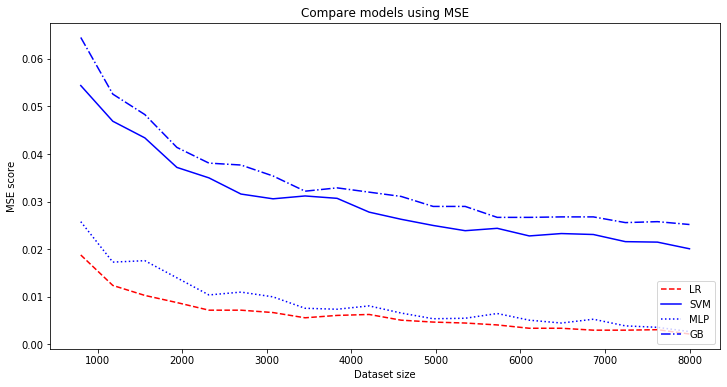

In [157]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(models_errs["LogisticRegression"]["mean_squared_error"][0], models_errs["LogisticRegression"]["mean_squared_error"][2], linestyle="--", color="r", label="LR")
ax.plot(models_errs["SVM"]["mean_squared_error"][0], models_errs["SVM"]["mean_squared_error"][2], linestyle="-", color="b", label="SVM")
ax.plot(models_errs["MLP"]["mean_squared_error"][0], models_errs["MLP"]["mean_squared_error"][2], linestyle="dotted", color="b", label="MLP")
ax.plot(models_errs["GradientBoosting"]["mean_squared_error"][0], models_errs["GradientBoosting"]["mean_squared_error"][2], linestyle="dashdot", color="b", label="GB")
ax.set_xlabel("Dataset size")
ax.set_ylabel("MSE score")
ax.set_title(f"Compare models using MSE")
ax.legend(loc="lower right")

In [24]:
def read_data(file_name):
    X=[]
    y=[]
    with zipfile.ZipFile(f"data/Lab11/{file_name}.zip","r") as zip_file:
        with zip_file.open(f"{file_name}.txt", "r") as inner_file:
            for line in inner_file:
                line=line.decode()
                challenge, response=line.split(" ")
                if not challenge.strip() or not response.strip():
                    continue
                X.append([int(num) for num in list(challenge)])
                y.append(int(response))
    return np.array(X), np.array(y)

In [163]:
base8_X, base8_y = read_data("Base8")
print(base8_X.shape)
base8_X=base8_X[:20000]
base8_y=base8_y[:20000]

(1000000, 8)


Evaluating logistic regression on Base8 dataset
Evaluating SVM on Base8 dataset
Evaluating MLP on Base8 dataset
Evaluating gradient boosting on Base8 dataset


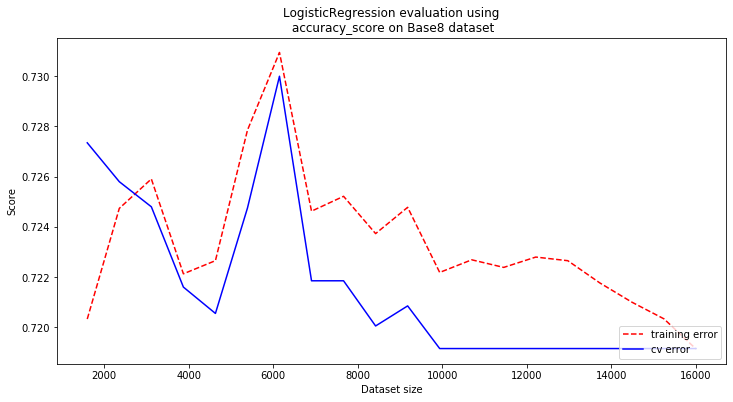

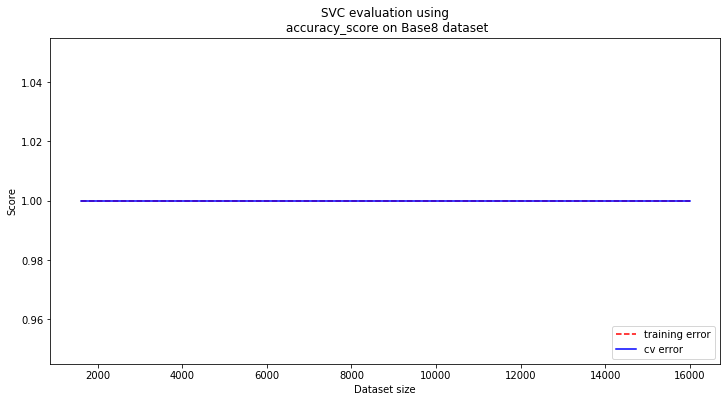

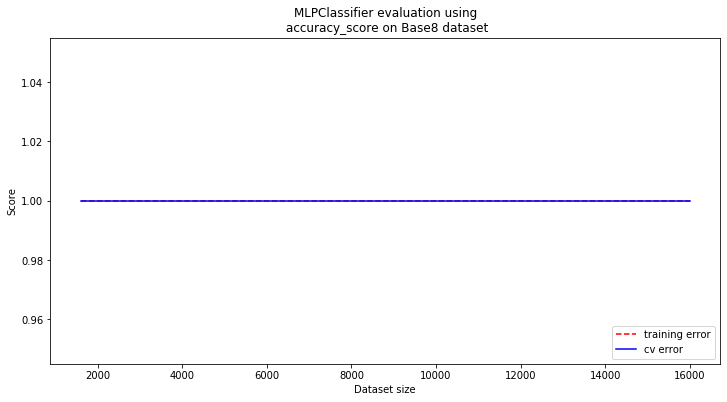

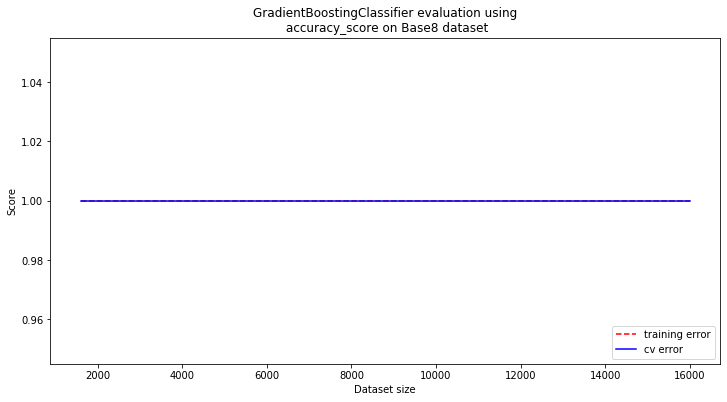

In [164]:
scorers=[accuracy_scorer]
models_errs=evaluate_models(base8_X, base8_y, "Base8", scorers)

In [165]:
base16_X, base16_y = read_data("Base16")
print(base16_X.shape)
base16_X=base16_X[:20000]
base16_y=base16_y[:20000]

(1000000, 16)


Evaluating logistic regression on Base16 dataset
Evaluating SVM on Base16 dataset
Evaluating MLP on Base16 dataset


C:\Users\Mikita_Ivanin\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Mikita_Ivanin\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Mikita_Ivanin\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Mikita_Ivanin\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: Convergenc

Evaluating gradient boosting on Base16 dataset


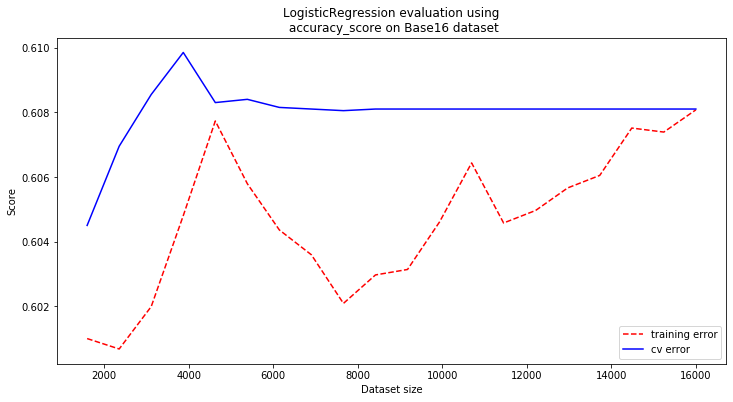

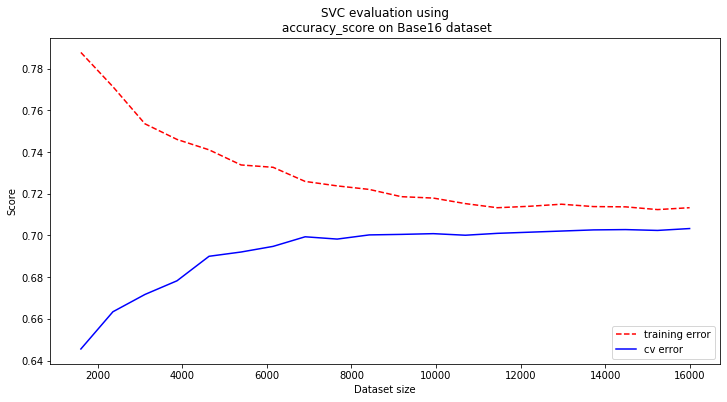

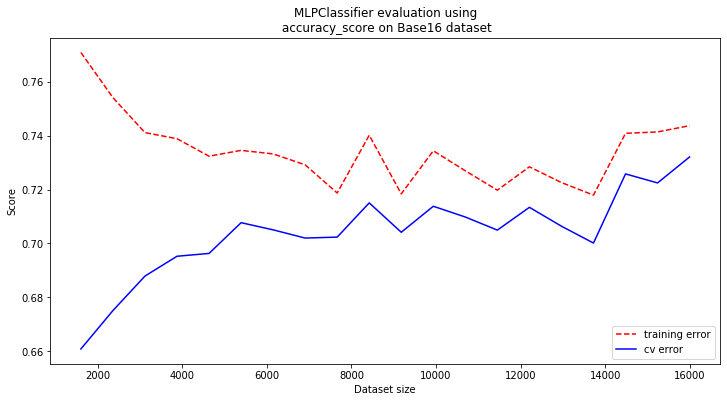

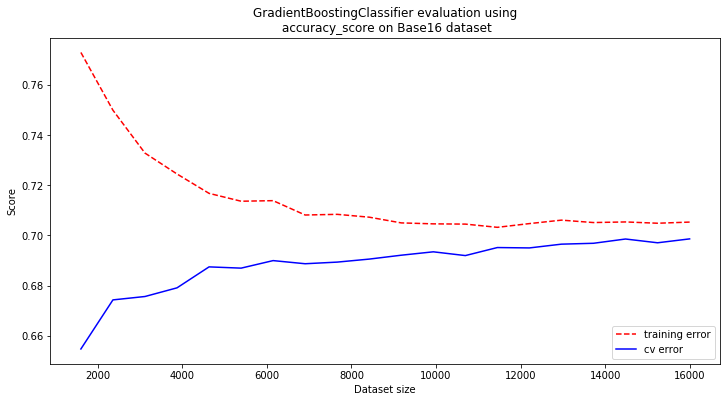

In [166]:
scorers=[accuracy_scorer]
models_errs=evaluate_models(base16_X, base16_y, "Base16", scorers)

In [167]:
base32_X, base32_y = read_data("Base32")
print(base32_X.shape)
base32_X=base32_X[:10000]
base32_y=base32_y[:10000]

(1000000, 32)


Evaluating logistic regression on Base32 dataset
Evaluating SVM on Base32 dataset
Evaluating MLP on Base32 dataset


C:\Users\Mikita_Ivanin\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Mikita_Ivanin\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Mikita_Ivanin\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Mikita_Ivanin\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: Convergenc

Evaluating gradient boosting on Base32 dataset


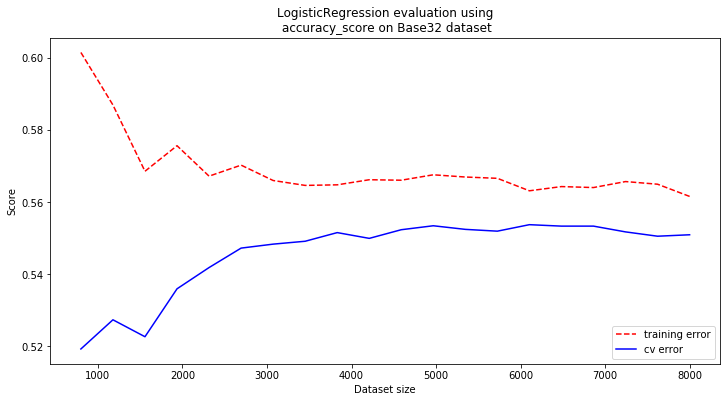

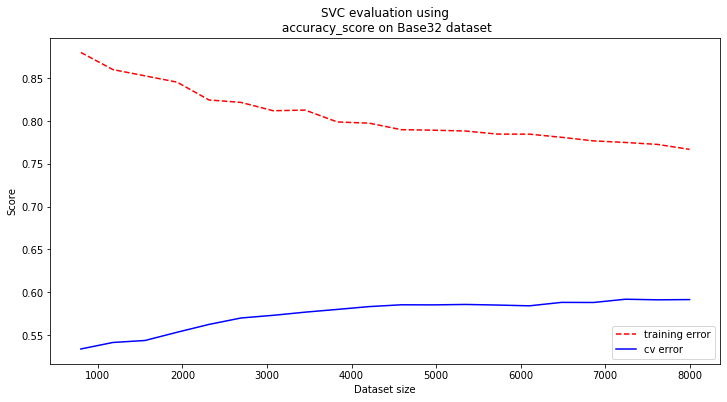

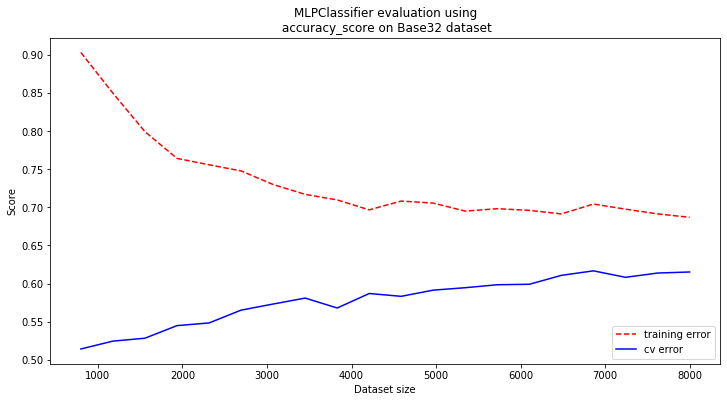

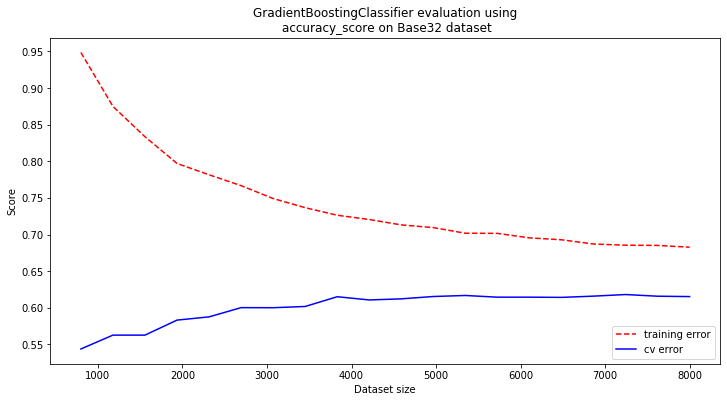

In [168]:
scorers=[accuracy_scorer]
models_errs=evaluate_models(base32_X, base32_y, "Base32", scorers)

In [169]:
base64_X, base64_y = read_data("Base64")
print(base64_X.shape)
base64_X=base64_X[:10000]
base64_y=base64_y[:10000]

(1000000, 64)


Evaluating logistic regression on Base64 dataset
Evaluating SVM on Base64 dataset
Evaluating MLP on Base64 dataset


C:\Users\Mikita_Ivanin\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Mikita_Ivanin\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Mikita_Ivanin\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Mikita_Ivanin\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: Convergenc

Evaluating gradient boosting on Base64 dataset


KeyboardInterrupt: 

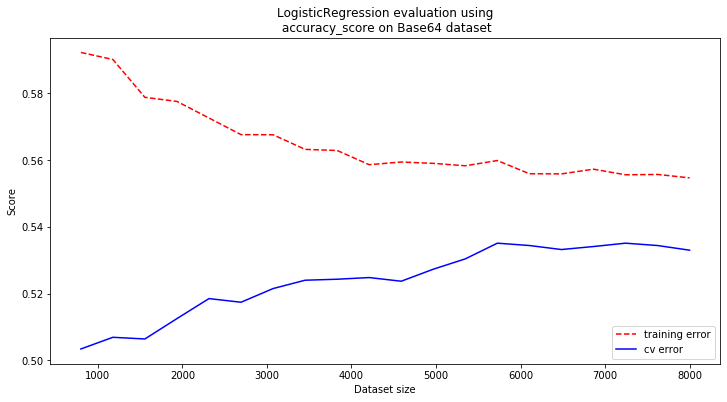

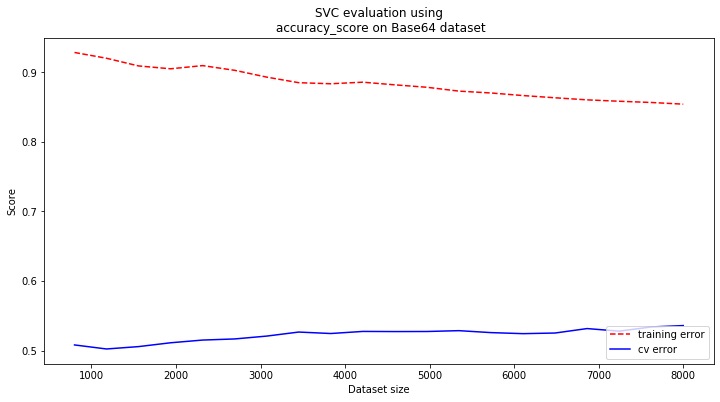

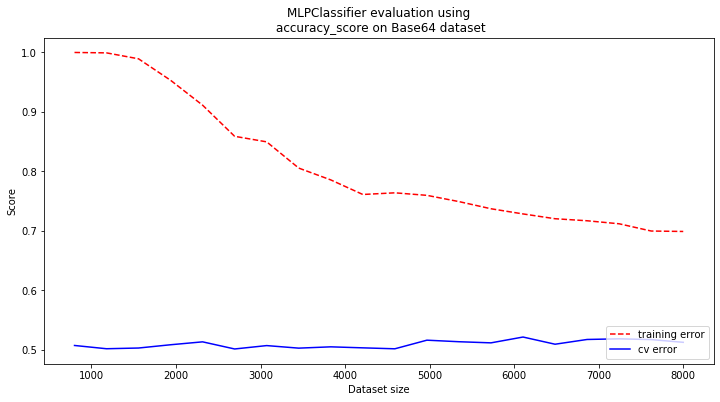

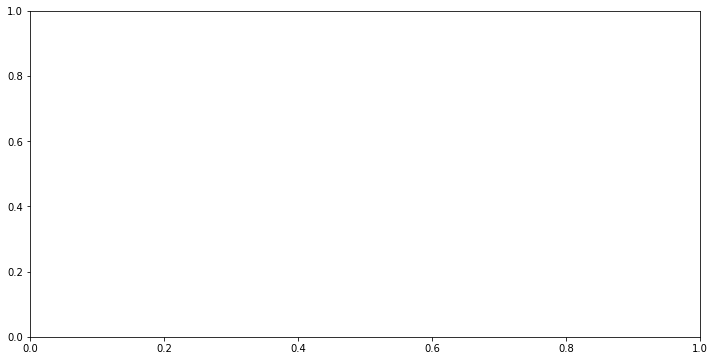

In [170]:
scorers=[accuracy_scorer]
models_errs=evaluate_models(base64_X, base64_y, "Base64", scorers)

In [17]:
base128_X, base128_y = read_data("Base128_1")
print(base128_X.shape)
base128_X=base128_X[:1000]
puf_simulator=PUFSimulator(128)
base128_X=np.apply_along_axis(puf_simulator.get_feature_vector,axis=1,arr=base128_X[:1000])
base128_y=base128_y[:1000]

(1000, 128)


Evaluating logistic regression on Base128 dataset
Evaluating SVM on Base128 dataset
Evaluating MLP on Base128 dataset


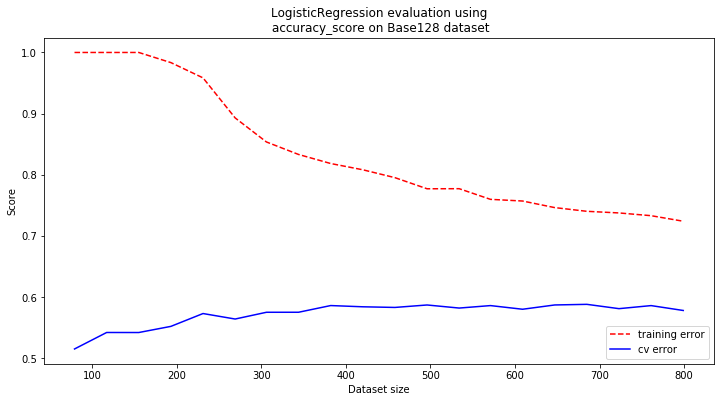

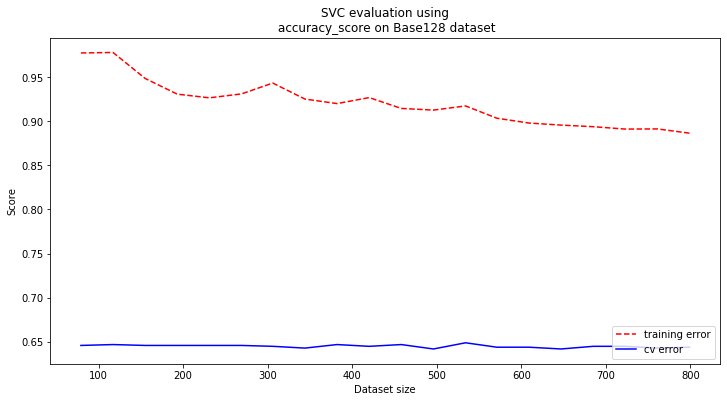

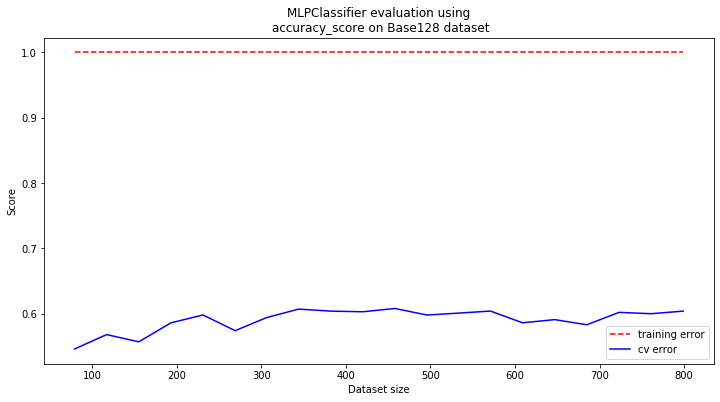

In [18]:
def evaluate_models(X, y, dataset_name, scorers):
    print(f"Evaluating logistic regression on {dataset_name} dataset")
    lr=LogisticRegression(solver='liblinear')
    lr_errs=plot_learning_curves(lr, X, y, scorers, dataset_name=dataset_name)
    print(f"Evaluating SVM on {dataset_name} dataset")
    svm=SVC(C=1, gamma='scale')
    svm_errs=plot_learning_curves(svm, X, y, scorers, dataset_name=dataset_name)
    print(f"Evaluating MLP on {dataset_name} dataset")
    mlp=MLPClassifier(
        hidden_layer_sizes=(puf_simulator.stages_num),
        alpha=1e-3,
        max_iter=1000
    )
    mlp_errs=plot_learning_curves(mlp, X, y, scorers, dataset_name=dataset_name)
    return {
        "LogisticRegression":lr_errs,
        "SVM":svm_errs,
        "MLP":mlp_errs
    }
accuracy_scorer=make_scorer(accuracy_score)
scorers=[accuracy_scorer]
models_errs=evaluate_models(base128_X, base128_y, "Base128", scorers)

(1999, 128)
Evaluating logistic regression on Base128 dataset
Evaluating SVM on Base128 dataset


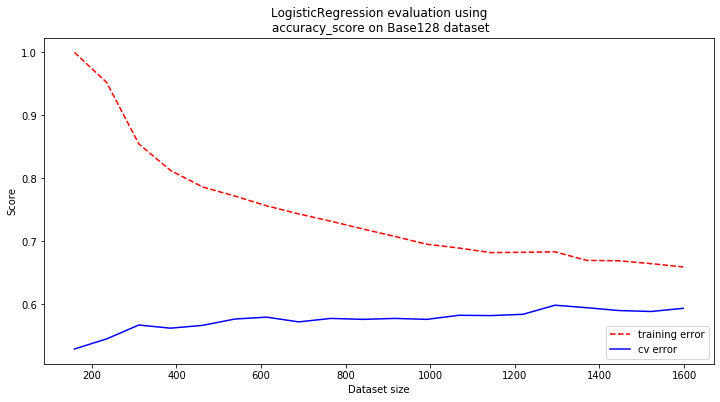

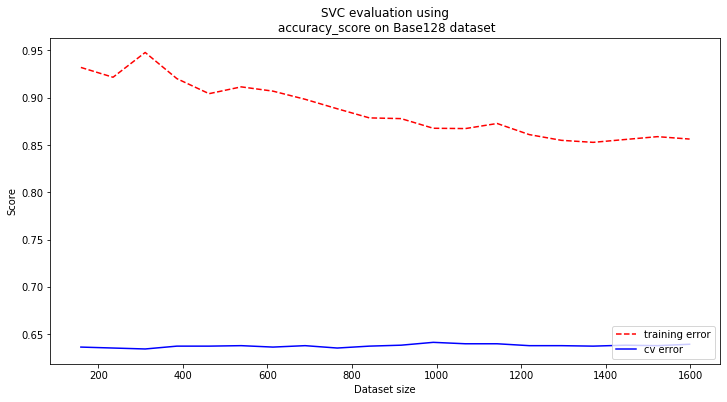

In [25]:
base128_X, base128_y = read_data("Base128_1")
print(base128_X.shape)
base128_X=base128_X[:2000]
puf_simulator=PUFSimulator(128)
base128_X=np.apply_along_axis(puf_simulator.get_feature_vector,axis=1,arr=base128_X[:2000])
base128_y=base128_y[:2000]
def evaluate_models(X, y, dataset_name, scorers):
    print(f"Evaluating logistic regression on {dataset_name} dataset")
    lr=LogisticRegression(solver='liblinear')
    lr_errs=plot_learning_curves(lr, X, y, scorers, dataset_name=dataset_name)
    print(f"Evaluating SVM on {dataset_name} dataset")
    svm=SVC(C=1, gamma='scale')
    svm_errs=plot_learning_curves(svm, X, y, scorers, dataset_name=dataset_name)
    return {
        "LogisticRegression":lr_errs,
        "SVM":svm_errs,
    }
accuracy_scorer=make_scorer(accuracy_score)
scorers=[accuracy_scorer]
models_errs=evaluate_models(base128_X, base128_y, "Base128", scorers)